# Import initial libraries 

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import mediapipe as mp
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, GRU, Dropout
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold

# Create MediaPipe Function for Detect Body

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections [FACEMESH_TESSELATION]
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=1, circle_radius=1)) 
    
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=1, circle_radius=1)) 
    
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=1, circle_radius=1)) 

# Test MediaPipe Function with real camera 

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

# Create Extract Function for Extract Feature

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Create Datasets

In [6]:
DATA_PATH_TRAIN = os.path.join('/GitHub/TSL_Recognition/TSL10/90_10/Train_Data')
actions = np.array(['Fine', 'Hello', 'Hungry', 'IAm', 'Like',
                    'Love', 'Sick', 'Sorry', 'Thanks', 'You'])
no_sequences_train = 90
sequence_length = 30

In [7]:
DATA_PATH_TEST = os.path.join('/GitHub/TSL_Recognition/TSL10/90_10/Test_Data')
actions = np.array(['Fine', 'Hello', 'Hungry', 'IAm', 'Like',
                    'Love', 'Sick', 'Sorry', 'Thanks', 'You'])
no_sequences_test = 10
sequence_length = 30

# Prepare Data for train and test

In [8]:
label_map = {label: num for num, label in enumerate(actions)}

sequences_train, labels_train = [], []
sequences_test, labels_test = [], []

def load_sequences(data_path, action, num_sequences):
    sequences = []
    labels = []
    for sequence in range(num_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])
    return sequences, labels


In [9]:

for action in actions:
    seq, lbl = load_sequences(DATA_PATH_TRAIN, action, no_sequences_train)
    sequences_train.extend(seq)
    labels_train.extend(lbl)

In [10]:

for action in actions:
    seq, lbl = load_sequences(DATA_PATH_TEST, action, no_sequences_test)
    sequences_test.extend(seq)
    labels_test.extend(lbl)

In [11]:
X_train = np.array(sequences_train)
y_train = to_categorical(labels_train).astype(int)
X_test = np.array(sequences_test)
y_test = to_categorical(labels_test).astype(int)

In [12]:
X_train.shape

(900, 30, 1662)

# Train model

Train GRU Model

In [13]:
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)

accuracy_scores = []
loss_scores = []
train_loss_scores = []
train_accuracy_scores = []

for train_index, test_index in skf.split(X_train, labels_train):
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]

    model_GRU = Sequential([
        GRU(64, return_sequences=True, activation='relu', input_shape=(30, 1662)),
        Dropout(0.1),
        GRU(128, return_sequences=True, activation='relu'),
        Dropout(0.1),
        GRU(64, return_sequences=False, activation='relu'),
        Dropout(0.1),
        Dense(64, activation='relu'),
        Dropout(0.1),
        Dense(32, activation='relu'),
        Dense(actions.shape[0], activation='softmax')
    ])

    model_GRU.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    history = model_GRU.fit(X_train_fold, y_train_fold, epochs=500, batch_size=32)

    _, accuracy = model_GRU.evaluate(X_test_fold, y_test_fold)
    accuracy_scores.append(accuracy)
    loss_scores.append(history.history['loss'])
    train_loss_scores.append(history.history['loss'])
    train_accuracy_scores.append(history.history['categorical_accuracy'])

Epoch 1/500
23/23 [==============================] - 6s 77ms/step - loss: 2.3094 - categorical_accuracy: 0.1181
Epoch 2/500
23/23 [==============================] - 2s 74ms/step - loss: 2.3030 - categorical_accuracy: 0.1056
Epoch 3/500
23/23 [==============================] - 2s 74ms/step - loss: 2.2978 - categorical_accuracy: 0.1250
Epoch 4/500
23/23 [==============================] - 2s 76ms/step - loss: 2.2947 - categorical_accuracy: 0.1153
Epoch 5/500
23/23 [==============================] - 2s 75ms/step - loss: 2.2807 - categorical_accuracy: 0.1708
Epoch 6/500
23/23 [==============================] - 2s 76ms/step - loss: 2.2352 - categorical_accuracy: 0.2042
Epoch 7/500
23/23 [==============================] - 2s 78ms/step - loss: 2.1726 - categorical_accuracy: 0.1861
Epoch 8/500
23/23 [==============================] - 2s 75ms/step - loss: 2.0650 - categorical_accuracy: 0.2208
Epoch 9/500
23/23 [==============================] - 2s 73ms/step - loss: 1.9176 - categorical_accuracy:

In [14]:
for fold, loss in enumerate(loss_scores):
    print(f"Loss for Fold {fold+1}: {loss[-1]}")

mean_loss = np.mean([loss[-1] for loss in loss_scores])
print("Mean loss:", mean_loss)

print("Accuracy scores for each fold:", accuracy_scores)
print("Mean accuracy:", np.mean(accuracy_scores))

Loss for Fold 1: 0.12155842036008835
Loss for Fold 2: 0.09849369525909424
Loss for Fold 3: 0.06095084175467491
Loss for Fold 4: 0.08560590445995331
Loss for Fold 5: 0.022912589833140373
Mean loss: 0.07790429033339023
Accuracy scores for each fold: [0.9055555462837219, 0.8999999761581421, 0.9277777671813965, 0.9055555462837219, 0.9277777671813965]
Mean accuracy: 0.9133333206176758


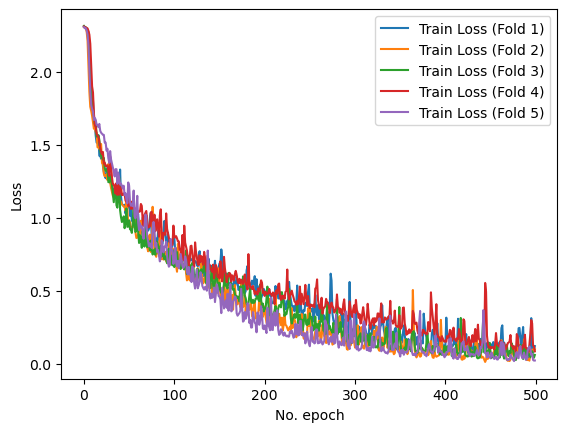

In [15]:
for fold, train_loss in enumerate(train_loss_scores):
    plt.plot(train_loss, label=f'Train Loss (Fold {fold+1})')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

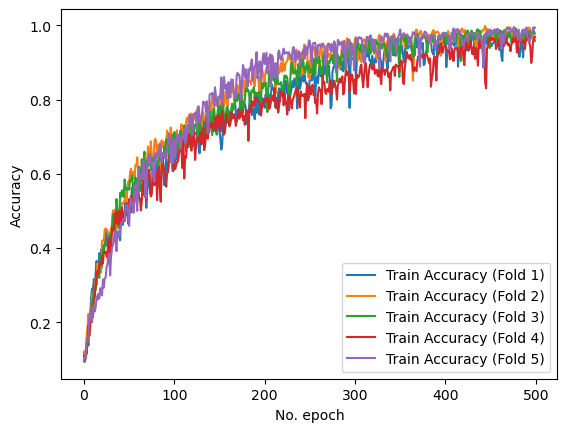

In [16]:
for fold, train_accuracy in enumerate(train_accuracy_scores):
    plt.plot(train_accuracy, label=f'Train Accuracy (Fold {fold+1})')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.legend()
plt.show()

In [ ]:
model_GRU.summary()

In [17]:
model_GRU.save('../GRU/90/GRU_Model_90.h5')

In [18]:
model_GRU = load_model('../GRU/90/GRU_Model_90.h5')

Test Accuracy Model

In [19]:
y_pred = model_GRU.predict(X_test)
y_true = np.argmax(y_test, axis=1).tolist()
y_pred = np.argmax(y_pred, axis=1).tolist()
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)

4/4 [==============================] - 3s 60ms/step


In [20]:
accuracies = []
for i, matrix in enumerate(confusion_matrices):
    tn, fp, fn, tp = matrix.ravel()
    label_accuracy = (tp + tn) / (tp + tn + fp + fn)
    accuracies.append(label_accuracy)
    print(f"Label {i + 1} accuracy: {label_accuracy}")

overall_accuracy = np.mean(accuracies)
print(f"Mean Accuracy: {overall_accuracy}")

Label 1 accuracy: 0.99
Label 2 accuracy: 1.0
Label 3 accuracy: 0.98
Label 4 accuracy: 0.98
Label 5 accuracy: 1.0
Label 6 accuracy: 0.99
Label 7 accuracy: 1.0
Label 8 accuracy: 0.99
Label 9 accuracy: 0.99
Label 10 accuracy: 1.0
Mean Accuracy: 0.992


# Test Model in real time

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
confidence = 0.9

cap = cv2.VideoCapture(0)

# Set mediapipe model
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)

        # Draw landmarks
        draw_styled_landmarks(image, results)

        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]

        if len(sequence) == 30:
            res = model_GRU.predict(np.expand_dims(sequence, axis=0))[0]
            predictions.append(np.argmax(res))

        # 3. Viz logic
            if np.unique(predictions[-15:])[0] == np.argmax(res):
                if res[np.argmax(res)] >= confidence:

                    if len(sentence) > 0:
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 1:
                sentence = sentence[-1:]

        cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
        cv2.putText(image, ''.join(sentence), (3, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Show to screen
        cv2.imshow('Result', image)

        # Break gracefully
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
        
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# sequence = []
# sentence = []
# predictions = []
# confidence = 0.5

# videos_path = '/GitHub/TSL_Recognition/TSL10/Videos_for_Test/__/'
# file_list = os.listdir(videos_path)
# video_files = [file for file in file_list if file.endswith(('.avi', '.mp4', '.mov'))]

# for video_file in video_files:
#     video_path = os.path.join(videos_path, video_file)
#     cap = cv2.VideoCapture(video_path)

#     with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
#         while cap.isOpened():
#             ret, image = cap.read()
#             if not ret:
#                 break

#             frame_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             results = holistic.process(frame_rgb)
#             draw_styled_landmarks(image, results)
#             keypoints = extract_keypoints(results)
#             sequence.append(keypoints)
#             sequence = sequence[-30:]

#             if len(sequence) == 30:
#                 res = model_GRU.predict(np.expand_dims(sequence, axis=0))[0]
#                 predictions.append(np.argmax(res))

#                 if np.unique(predictions[-15:])[0] == np.argmax(res):
#                     if res[np.argmax(res)] >= confidence:

#                         if len(sentence) > 0:
#                             if actions[np.argmax(res)] != sentence[-1]:
#                                 sentence.append(actions[np.argmax(res)])
#                         else:
#                             sentence.append(actions[np.argmax(res)])

#                 if len(sentence) > 1:
#                     sentence = sentence[-1:]
#             print(sentence)
#             cv2.rectangle(image, (0, 0), (640, 40), (0, 204, 102), -1)
#             cv2.putText(image, ' '.join(sentence), (3, 30),
#             cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
#             cv2.imshow('Video', image)

#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break

#     cap.release()

# cv2.destroyAllWindows()